In [1]:
import re
import string
import os
import gc
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime as dt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sqlalchemy.engine.base import Engine
from yaml import safe_load

from database.database import engine
from config.config import PG_USER, PG_PASS, PG_HOST, PG_PORT, PG_DB


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [4]:
def select(query: str, conn: Engine=engine) -> pd.DataFrame:
    return pd.read_sql(query, conn)
    
users_query = "SELECT * FROM public.user_data"
posts_query = "SELECT * FROM public.post_text_df"
feeds_query = "SELECT * FROM public.feed_data WHERE action = 'view' LIMIT 5000000"

users_df = select(users_query)
posts_df = select(posts_query)
feeds_df = select(feeds_query)

In [6]:
# posts_df.to_parquet("./postgres/init_data/posts.parquet")
# users_df.to_parquet("./postgres/init_data/users.parquet")
# feeds_df.to_parquet("./postgres/init_data/feeds.parquet")

# posts_df.to_csv("./postgres/init_data/posts.csv", sep = ",", index = False)
# users_df.to_csv("./postgres/init_data/users.csv", sep = ",", index = False)
# feeds_df.to_csv("./postgres/init_data/feeds.csv", sep = ",", index = False)  

In [7]:
users_df.shape, posts_df.shape, feeds_df.shape

((163205, 8), (7023, 3), (5000000, 5))

In [8]:
posts_df.head(2)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufacturing sector will continue to face serious chall...,business
1,2,Aids and climate top Davos agenda\n\nClimate change and the fight against Aids are leading the l...,business


In [9]:
nltk.download('./wordnet')
nltk.download('./punkt')
nltk.download('./stopwords')


punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocessing(text):
    tokens_list = word_tokenize(text.lower())
    punctuation_free = [token for token in tokens_list if token not in punctuation]
    stop_words_free = [token for token in punctuation_free if token not in stop_words]
    digits_free = [token for token in stop_words_free if not re.search(r'\d', token)]
    lemmatized = " ".join([lemmatizer.lemmatize(word) for word in digits_free]) 
    return lemmatized


vectorizer = TfidfVectorizer(preprocessor=preprocessing)
transformed_output = vectorizer.fit_transform(posts_df['text']).toarray()
tfidf_df = pd.DataFrame(
    transformed_output,
    index=posts_df.post_id,
    columns=vectorizer.get_feature_names_out())

posts_df['TotalTfIdf'] = tfidf_df.sum(axis=1).reset_index()[0]
posts_df['MaxTfIdf'] = tfidf_df.max(axis=1).reset_index()[0]
posts_df['MeanTfIdf'] = tfidf_df.mean(axis=1).reset_index()[0]


centered = tfidf_df - tfidf_df.mean(axis=0)
pca = PCA(n_components=30)
pca_decomp = pca.fit_transform(centered)


kmeans = KMeans(n_clusters=20, random_state=0).fit(pca_decomp)
posts_df['TextCluster'] = kmeans.labels_
dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster',
                 'DistanceTo16thCluster',
                 'DistanceTo17thCluster',
                 'DistanceTo18thCluster',
                 'DistanceTo19thCluster',
                 'DistanceTo20thCluster']
kmeans_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)
kmeans_df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/radionnazmiev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/radionnazmiev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/radionnazmiev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,0.459902,0.512822,0.495863,0.545229,0.455107,0.446442,0.492760,0.582338,0.466398,0.722446,0.555234,0.136211,0.525738,0.580367,0.493562,0.472021,0.530356,0.393136,0.496764,0.499244
1,0.340645,0.405914,0.367938,0.424858,0.333653,0.251573,0.379997,0.499970,0.351017,0.635228,0.468126,0.367894,0.443568,0.361821,0.396540,0.370155,0.435440,0.253946,0.384407,0.391418
2,0.391996,0.433948,0.443161,0.455984,0.366116,0.385998,0.412395,0.518448,0.385032,0.657976,0.498802,0.285530,0.472005,0.554831,0.446790,0.404407,0.466126,0.232061,0.427790,0.444424
3,0.388593,0.438125,0.445951,0.458510,0.371093,0.370012,0.416002,0.476596,0.372749,0.625023,0.479764,0.408305,0.483190,0.544728,0.441754,0.417743,0.473076,0.251635,0.421881,0.444940
4,0.245221,0.294249,0.321186,0.362253,0.176129,0.225382,0.265199,0.406045,0.200425,0.571966,0.363121,0.347469,0.362826,0.444124,0.319386,0.238918,0.327651,0.096679,0.276014,0.301828


In [11]:
posts_df = pd.concat((posts_df,kmeans_df),axis=1)
# posts_df.to_parquet("./postgres/init_data/processed_posts.parquet")
# posts_df.to_csv("./postgres/init_data/processed_posts.csv", sep = ",", index = False)
posts_df.head(2)

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,1,UK economy facing major risks\n\nThe UK manufacturing sector will continue to face serious chall...,business,9.015487,0.489283,0.000208,11,0.459902,0.512822,0.495863,0.545229,0.455107,0.446442,0.492760,0.582338,0.466398,0.722446,0.555234,0.136211,0.525738,0.580367,0.493562,0.472021,0.530356,0.393136,0.496764,0.499244
1,2,Aids and climate top Davos agenda\n\nClimate change and the fight against Aids are leading the l...,business,12.082760,0.313700,0.000279,5,0.340645,0.405914,0.367938,0.424858,0.333653,0.251573,0.379997,0.499970,0.351017,0.635228,0.468126,0.367894,0.443568,0.361821,0.396540,0.370155,0.435440,0.253946,0.384407,0.391418


In [12]:
posts_df.to_sql(
   "posts_info_by_radion_nazmiev",
    con=engine,
    schema="public",
    if_exists='replace'
)

23

In [13]:
del users_query
del posts_query
del feeds_query
del nltk
del punctuation
del stop_words
del lemmatizer
del vectorizer
del transformed_output
del tfidf_df
del centered
del pca
del pca_decomp
del kmeans
del dists_columns
del kmeans_df
del PCA
del KMeans

gc.collect()

23

In [14]:
df = pd.merge(
    feeds_df,
    posts_df,
    on='post_id',
    how='inner'
)
df = pd.merge(
    users_df,
    df,
    on='user_id',
    how='inner'
)

df.shape

(5000000, 38)

In [15]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month

del feeds_df
del posts_df
del users_df

df = df.set_index(['user_id', 'post_id'])

df.head(2)

gender  age country     city  exp_group       os source  \
user_id post_id                                                            
6578    7281          0   28  Russia  Kolpino          3  Android    ads   
        1665          0   28  Russia  Kolpino          3  Android    ads   

                          timestamp action  target  \
user_id post_id                                      
6578    7281    2021-11-24 15:47:36   view       0   
        1665    2021-10-28 23:28:29   view       0   

                                                                                                                text  \
user_id post_id                                                                                                        
6578    7281     Wealthy widower Anthony Steffen (as Alan Cunningham) is a sadomasochistic lover, and British Lor...   
        1665     Benitez joy as Reds take control\n\nLiverpool boss Rafael Benitez was satisfied after his teams ...   

                 topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                        
6578    7281     movie    6.458608  0.388199   0.000149            4   
        1665     sport    8.231754  0.489081   0.000190           15   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
6578    7281                 0.288054              0.242301   
        1665                 0.399446              0.401220   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
6578    7281                 0.295463              0.381608   
        1665                 0.387810              0.333887   

                 DistanceTo5thCluster  DistanceTo6thCluster  \
user_id post_id                                               
6578    7281                 0.116562              0.234487   
        1665                 0.335164              0.371799   

                 DistanceTo7thCluster  DistanceTo8thCluster  \
user_id post_id                                               
6578    7281                 0.233179              0.401814   
        1665                 0.380453              0.518635   

                 DistanceTo9thCluster  DistanceTo10thCluster  \
user_id post_id                                                
6578    7281                 0.159051               0.623661   
        1665                 0.371113               0.686891   

                 DistanceTo11thCluster  DistanceTo12thCluster  \
user_id post_id                                                 
6578    7281                  0.347201               0.373474   
        1665                  0.479609               0.462274   

                 DistanceTo13thCluster  DistanceTo14thCluster  \
user_id post_id                                                 
6578    7281                  0.359029               0.441786   
        1665                  0.366975               0.536227   

                 DistanceTo15thCluster  DistanceTo16thCluster  \
user_id post_id                                                 
6578    7281                  0.294832               0.239467   
        1665                  0.331913               0.156808   

                 DistanceTo17thCluster  DistanceTo18thCluster  \
user_id post_id                                                 
6578    7281                  0.301233               0.180400   
        1665                  0.455670               0.351579   

                 DistanceTo19thCluster  DistanceTo20thCluster  hour  month  
user_id post_id                                                             
6578    7281                  0.247176               0.295162    15     11  
        1665                  0.393039               0.426280    23     10

In [16]:
max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:05:25'))

In [17]:
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop(['timestamp','action', 'text'], axis=1)
df_test = df_test.drop(['timestamp','action', 'text'], axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']
del df
del df_train
del df_test

y_train.shape, y_test.shape

((4163571,), (836429,))

In [18]:
object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]


cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)


pipe_dt = Pipeline([("column_transformer",
                     col_transform),

                    ("decision_tree",
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

/media/radionnazmiev/Data/DS/recommendation_system_project/venv/lib/python3.8/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/media/radionnazmiev/Data/DS/recommendation_system_project/venv/lib/python3.8/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/media/radionnazmiev/Data/DS/recommendation_system_project/venv/lib/python3.8/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/media/radionnaz

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [0, 33, 5, 6]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [7, 11, 2, 3, 4, 32])])),
                ('decision_tree', DecisionTreeClassifier())])

In [19]:
print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9197887910534166
Качество на тесте: 0.5351104822641464


In [20]:
catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2,
                              random_seed=100)

catboost.fit(X_train, y_train, object_cols, logging_level='Verbose')

/media/radionnazmiev/Data/DS/recommendation_system_project/venv/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.3565824	total: 636ms	remaining: 1m 2s
1:	learn: 0.3499218	total: 1.05s	remaining: 51.5s
2:	learn: 0.3488073	total: 1.49s	remaining: 48.3s
3:	learn: 0.3482198	total: 1.88s	remaining: 45.1s
4:	learn: 0.3480453	total: 2.32s	remaining: 44.1s
5:	learn: 0.3479588	total: 2.74s	remaining: 43s
6:	learn: 0.3478816	total: 3.13s	remaining: 41.5s
7:	learn: 0.3478201	total: 3.49s	remaining: 40.1s
8:	learn: 0.3475669	total: 3.87s	remaining: 39.1s
9:	learn: 0.3475364	total: 4.24s	remaining: 38.2s
10:	learn: 0.3474360	total: 4.6s	remaining: 37.2s
11:	learn: 0.3466883	total: 4.98s	remaining: 36.5s
12:	learn: 0.3466681	total: 5.32s	remaining: 35.6s
13:	learn: 0.3466044	total: 5.68s	remaining: 34.9s
14:	learn: 0.3465650	total: 6.04s	remaining: 34.2s
15:	learn: 0.3465325	total: 6.39s	remaining: 33.6s
16:	learn: 0.3465148	total: 6.74s	remaining: 32.9s
17:	learn: 0.3459135	total: 7.12s	remaining: 32.4s
18:	learn: 0.3459021	total: 7.47s	remaining: 31.8s
19:	learn: 0.3458401	total: 7.83s	remaining:

In [21]:
print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6653056088181004


/media/radionnazmiev/Data/DS/recommendation_system_project/venv/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Качество на тесте: 0.6471911304173775


In [22]:
catboost.save_model('catboost_model')

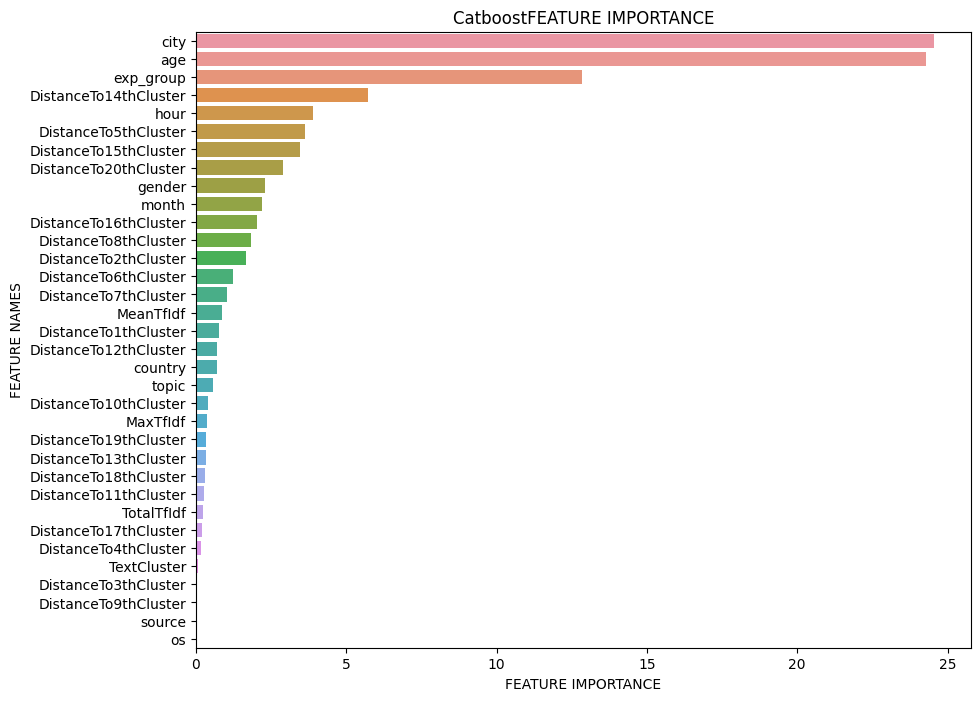

In [23]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')